# Проект 'Обнаружение проблем в работе оборудования'
## Описание проекта
Даже самое надёжное оборудование в процессе эксплуатации подвержено износу, который может привести к его выходу из строя. За счёт своевременных ремонтных работ можно постараться нивелировать данный износ и не допустить простоя оборудования из-за его поломок. Но для заблаговременного обнаружения проблем/неполадок в работе оборудования необходимо понимать насколько хорошо оно работает в текущий момент времени. В настоящий момент для такого класса задач широкое распространение получила вибрационная диагностика, позволяющая за счёт анализа данных от датчика вибраций делать выводы о состоянии деталей и узлов оборудования. В данном проекте используется датчик вибраций, прикрепляемый к корпусу оборудования. Датчик фиксирует 12 максимальных амплитуд и соответствующих им частот каждые 0.5 сек.

## Цель проекта
Минимизировать риск внезапного выхода из строя оборудования за счёт сигнализирования о начавшихся возможных проблемах в его работе по данным от датчика вибраций. В свою очередь это позволит:  
1) сэкономить средства на замене сломанного оборудования;  
2) сократить потери времени на перепланирование производства в связи с выходом из строя оборудования.   

## Ожидаемый результат
Программный код, выполняющий анализ данных, фиксируемых датчиком вибраций. Программа должна классифицировать данные, диагностирующие исправную и неисправную работу оборудования.

In [1]:
# Импорт зависимостей
from datetime import timedelta
from time import perf_counter
import itertools
import pickle

from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 1234  # начальное значение для генератора случайных чисел
np.random.seed(seed)

# 0. Подготовка данных, диагностирующих неисправность (Не включать данный раздел в проект)
> !!! Внимание: этот раздел не нужно выполнять, он только показывает как были получены данные диагностирующие неисправность
Этот раздел не должен быть включен в ваши проекты. Дело в том, что в реальности не было возможности снять данные с плохо работающего станка, поэтому они были сгенерированы только в рамках данного проекта для Академии Калашников.

In [2]:
# Загрузить данные из файла
t1 = perf_counter()
path = 'correct_data.csv'
correct_data = np.genfromtxt(
    fname=path, dtype=np.float64, delimiter=',', 
    skip_header=1, usecols=range(2, 50), 
    invalid_raise=False
)

# Сгенерировать шум для амплитуд и частот
n = 12
malfunction_data = np.zeros(shape=(correct_data.shape[0], 49))
for idx, row in enumerate(correct_data):
    part1 = row[list(range(0, n))]  # амплитуды
    part2 = row[list(range(n, 2*n))]  # частоты
    part3 = row[list(range(2*n, 3*n))]  # амплитуды
    part4 = row[list(range(3*n, 4*n))]  # частоты
    if np.random.random() < 0.5:
        noise_part1 = np.random.normal(0.18, 0.5, size=part1.shape)
        part1 = np.clip(part1 + noise_part1, a_min=0, a_max=2)
        
        noise_part2 = np.random.normal(0, 8, size=part2.shape)
        part2 = np.clip(part2 + noise_part2, a_min=0, a_max=512)
    else:
        noise_part3 = np.random.normal(0.18, 0.5, size=part3.shape)
        part3 = np.clip(part3 + noise_part3, a_min=0, a_max=2)
        
        noise_part4 = np.random.normal(0, 8, size=part4.shape)
        part4 = np.clip(part4 + noise_part4, a_min=0, a_max=512)
    
    malfunction_data[idx] = np.hstack(([12], part1, part2, part3, part4))

# Сохранить данные в файл
pd.DataFrame(data=malfunction_data).to_csv('malfunction_data.csv')
print(f"Подготовка данных (неисправность) завершена за {timedelta(seconds=perf_counter()-t1)}")

Подготовка данных (неисправность) завершена за 0:01:10.044106


# 1. Загрузка данных

## Описание формата данных
Каждая строка в файле с данными записывается с помощью датчика вибраций каждые 0.5 сек. и состоит из следующих элементов: 
- нулевой элемент - всегда равен 12 и является сервисной информацией, означает количество максимальных амплитуд и соответствующих им частот. Обратите внимание, что столбец с данной информацией для последующей обработки не загружается.
- элементы [1-12] - максимальные амплитуды для первой оси
- элементы [13-24] - частоты первой оси, соответствующие максимальным амплитудам
- элементы [25-36] - максимальные амплитуды для второй оси
- элементы [37-48] - частоты второй оси, соответствующие максимальным амплитудам

Пример данных:  
<img src="./illustrations/raw_data_example.png" width="1300" height="900" align=left>

## 1.1. Загрузка данных, соответствующих нормальной работе оборудования

In [3]:
# Загрузить из файла данные, соответствующие нормальной работе оборудования
t1 = perf_counter()
path = 'correct_data.csv'
correct_data = np.genfromtxt(
    fname=path, dtype=np.float64, delimiter=',', 
    skip_header=1, usecols=range(2, 50), 
    invalid_raise=False
)
print(f"Загрузка данных завершена за {timedelta(seconds=perf_counter()-t1)}")
print(f"Всего строк в данных: {len(correct_data)}")

# Показать для примера первую строку в данных
correct_data[0:1]

Загрузка данных завершена за 0:00:15.343200
Всего строк в данных: 522570


array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. , 25.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ]])

## 1.2. Загрузка данных, диагностирующих неисправность в работе оборудования

In [4]:
# Загрузить из файла данные, диагностирующие несиправность в работе оборудования
t1 = perf_counter()
path = 'malfunction_data.csv'
malfunction_data = np.genfromtxt(
    fname=path, dtype=np.float64, delimiter=',', 
    skip_header=1, usecols=range(2, 50), 
    invalid_raise=False
)
print(f"Загрузка данных завершена за {timedelta(seconds=perf_counter()-t1)}")
print(f"Всего строк в данных: {len(malfunction_data)}")

# Показать для примера первую строку в данных
malfunction_data[0:1]

Загрузка данных завершена за 0:00:19.612385
Всего строк в данных: 522570


array([[0.00000000e+00, 1.19341629e+00, 5.11254519e-01, 5.17623172e-01,
        0.00000000e+00, 0.00000000e+00, 1.46965900e-02, 6.17063956e-01,
        1.18127480e+00, 1.85431038e-01, 0.00000000e+00, 8.92492049e-01,
        1.16647280e+00, 2.31527276e+01, 0.00000000e+00, 6.89328803e+00,
        0.00000000e+00, 1.49997897e+00, 4.83446994e+00, 0.00000000e+00,
        0.00000000e+00, 1.32709827e+01, 0.00000000e+00, 8.32868775e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.56000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# 2. Разведочный анализ данных (Exploratory Data Analysis)

> Выясним имеются ли в данных выбросы и отобразим гистограммы распределений для амплитуд и частот. Выбросы (измерения, выделяющиеся из общей выборки) могут возникать в результате воздействия случайных сторонних факторов.

## Вспомогательные функции для анализа данных

In [5]:
def check_data_quality(data, n=12, ampl_thresh=2, freq_thresh=512):
    """Функция показывает статистику по тем строкам в данных,
    в которых амплитуда или частота превышают пороговые значения.
    
    Параметры
    ----------
    data: array. Строки с амплитудами и частотами.
    n: int. Количество амплитуд и частот в строке в разрезе каждой оси.
    ampl_thresh: float. Пороговое значение для амплитуды. Если значение амплитуды больше,
    то считаем что это выброс.
    freq_thresh: float. Пороговое значение для частоты. Если значение частоты больше,
    то считаем что это выброс.
    
    Результат
    -------
    None.
    """
    
    data_ampl = data[:, [list(range(0, n)) + list(range(2*n, 3*n))]]
    outliers = data_ampl[data_ampl > ampl_thresh]
    if len(outliers) > 0:
        print(f"Выбросы у амплитуд (> {ampl_thresh}): {stats.describe(outliers)}")
    else:
        print("Выбросы у амплитуд отсутствуют")
    
    data_freq = data[:, [list(range(n, 2*n)) + list(range(3*n, 4*n))]]
    outliers = data_freq[data_freq > freq_thresh]
    if len(outliers) > 0:
        print(f"Выбросы у частот (> {freq_thresh}): {stats.describe(outliers)}")
    else:
        print("Выбросы у частот отсутствуют")

        
def clean_data(data, n=12,
               ampl_flag=True, ampl_thresh=2,
               freq_flag=True, freq_thresh=512):
    """Функция изменяет амплитуды и частоты, превышающие пороговые значения, на их пороговые значения.
    
    Параметры
    ----------
    data: array. Строки с амплитудами и частотами.
    n: int. Количество амплитуд и частот в строке в разрезе каждой оси.
    ampl_flag: bool. Если значение True, то производить изменение амплитуд.
    ampl_thresh: float. Пороговое значение для амплитуды. Если значение амплитуды больше,
    то считаем что это выброс.
    freq_flag: bool. Если значение True, то производить изменение частот.
    freq_thresh: float. Пороговое значение для частоты. Если значение частоты больше,
    то считаем что это выброс.
    
    Результат
    -------
    clean_data: array. Строки с амплитудами и частотами, укладывающимися в пороговые значения.
    """

    part1 = data[:, list(range(0, n))]  # амплитуды
    part2 = data[:, list(range(n, 2*n))]  # частоты
    part3 = data[:, list(range(2*n, 3*n))]  # амплитуды
    part4 = data[:, list(range(3*n, 4*n))]  # частоты

    if ampl_flag:
        part1[part1 > ampl_thresh] = ampl_thresh
        part3[part3 > ampl_thresh] = ampl_thresh
    
    if freq_flag:
        part2[part2 > freq_thresh] = freq_flag
        part4[part4 > freq_thresh] = freq_flag
  
    return np.hstack((part1, part2, part3, part4))


def plot_histogram(data, n=12, figsize=(10, 6)):
    """ Функция строит гистограмму для частот и амплитуд.
    
    Параметры
    ----------
    data: array. Строки с амплитудами и частотами.
    n: int. Количество амплитуд и частот в строке в разрезе каждой оси.
    figsize: tuple. Размер фигуры (ширина, высота).
    
    Результат
    -------
    None.
    """
    
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    
    amplitude = data[:, [list(range(0, n))]].flatten()
    print(f"Статистика для амплитуд оси 1: {stats.describe(amplitude)}")
    ax[0][0].hist(amplitude, density=True)
    ax[0][0].set_title('Амплитуды оси 1')
    
    frequency = data[:, [list(range(n, 2*n))]].flatten()
    print(f"Статистика для частот оси 1: {stats.describe(frequency)}")
    ax[0][1].hist(frequency, density=True)
    ax[0][1].set_title('Частоты оси 1')

    amplitude = data[:, [list(range(2*n, 3*n))]].flatten()
    print(f"Статистика для амплитуд оси 2: {stats.describe(amplitude)}")
    ax[1][0].hist(amplitude, density=True)
    ax[1][0].set_title('Амплитуды оси 2')
      
    frequency = data[:, [list(range(3*n, 4*n))]].flatten()
    print(f"Статистика для частот оси 2: {stats.describe(frequency)}")
    ax[1][1].hist(frequency, density=True)
    ax[1][1].set_title('Частоты оси 2')   
    
    fig.tight_layout()

## 2.1. Анализ данных, соответствующих нормальной работе оборудования

In [6]:
# Проверить данные на наличие выбросов
check_data_quality(correct_data)

Выбросы у амплитуд (> 2): DescribeResult(nobs=6408, minmax=(2.000023, 8191.875), mean=280.8718206939919, variance=675095.4261890579, skewness=5.189883206763977, kurtosis=35.96794977716712)
Выбросы у частот (> 512): DescribeResult(nobs=1173, minmax=(512.2, 6553.5), mean=1952.311338448423, variance=1722507.7148286677, skewness=1.3894776396434034, kurtosis=2.2361201259830876)


> Как видно есть строки в которых амплитуды и/ или частоты превышают их пороговые значения.  
Есть разные варианты обработки выбросов. Например, удаление наблюдений с выбросами, или их исправление, т.е. присвоение значений не превышающих пороговые. Выберем второй вариант - исправлений значений выбросов.

In [7]:
# Сделать корректировку амплитуд и частот
# согласно их пороговым значениям
correct_data = clean_data(correct_data)

# Снова проверить данные на наличие выбросов
# чтобы убедиться в отсутствии выбросов после корректировки
check_data_quality(correct_data)

Выбросы у амплитуд отсутствуют
Выбросы у частот отсутствуют


> При работе с данными их важно визуализировать, чтобы лучше понять их.
Построим гистограммы распределений для амплитуд и частот.

Статистика для амплитуд оси 1: DescribeResult(nobs=6270840, minmax=(0.0, 2.0), mean=0.41939569075916233, variance=0.016696579457844158, skewness=0.3323368059272499, kurtosis=14.352100798958645)
Статистика для частот оси 1: DescribeResult(nobs=6270840, minmax=(0.0, 512.0), mean=92.90826578257457, variance=8959.530077266601, skewness=1.31308315956574, kurtosis=1.5365697918154044)
Статистика для амплитуд оси 2: DescribeResult(nobs=6270840, minmax=(0.0, 2.0), mean=0.4334412258035173, variance=0.01870983082076092, skewness=0.5291200965647119, kurtosis=13.742665385115433)
Статистика для частот оси 2: DescribeResult(nobs=6270840, minmax=(0.0, 512.0), mean=181.55060966313917, variance=33306.32419328725, skewness=0.5958305001032423, kurtosis=-1.3291951411019194)


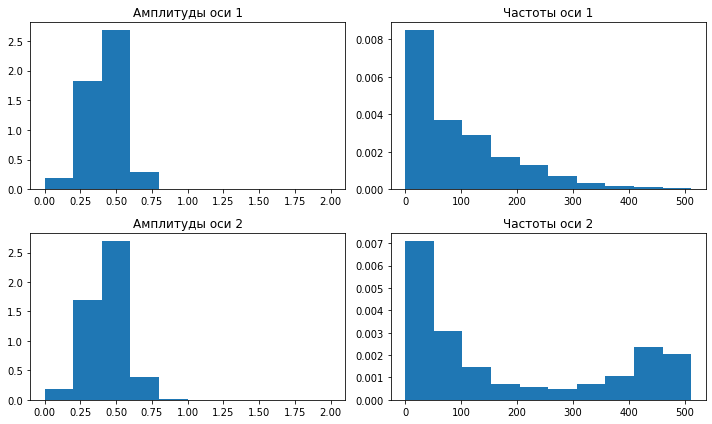

In [8]:
# Построить гистограммы для амплитуд и частот
plot_histogram(correct_data, n=12, figsize=(10, 6))

> Как можно заметить частоты для оси 1 и 2 отличаются. Таким образом, для последующего решения задачи важны данные с обеих осей.

## 2.2. Анализ данных, диагностирующих неисправность в работе оборудования

In [9]:
# Проверить данные на наличие выбросов
check_data_quality(malfunction_data)

Выбросы у амплитуд (> 2): DescribeResult(nobs=3189, minmax=(2.000023, 8191.875), mean=283.3979370834431, variance=692845.225476311, skewness=5.110915009739307, kurtosis=34.53656953424123)
Выбросы у частот (> 512): DescribeResult(nobs=596, minmax=(512.2, 6553.5), mean=2007.0191275167788, variance=1872111.1788604138, skewness=1.4797342747177396, kurtosis=2.3947754893270723)


In [10]:
# Сделать корректировку амплитуд и частот
# согласно их пороговым значениям
malfunction_data = clean_data(malfunction_data)

# Снова проверить данные на наличие выбросов
# чтобы убедиться в отсутствии выбросов после корректировки
check_data_quality(malfunction_data)

Выбросы у амплитуд отсутствуют
Выбросы у частот отсутствуют


Статистика для амплитуд оси 1: DescribeResult(nobs=6270840, minmax=(0.0, 2.0), mean=0.524911658207563, variance=0.12552690490822696, skewness=1.1927589152406297, kurtosis=1.8777349579993938)
Статистика для частот оси 1: DescribeResult(nobs=6270840, minmax=(0.0, 512.0), mean=93.14824391055814, variance=8957.10416885554, skewness=1.3171014643252072, kurtosis=1.5531702621782317)
Статистика для амплитуд оси 2: DescribeResult(nobs=6270840, minmax=(0.0, 2.0), mean=0.5382442331462951, variance=0.12797594163974138, skewness=1.1665935938187364, kurtosis=1.8239184765062566)
Статистика для частот оси 2: DescribeResult(nobs=6270840, minmax=(0.0, 512.0), mean=181.7459875857242, variance=33263.04117410809, skewness=0.5965050734202424, kurtosis=-1.3274526557934734)


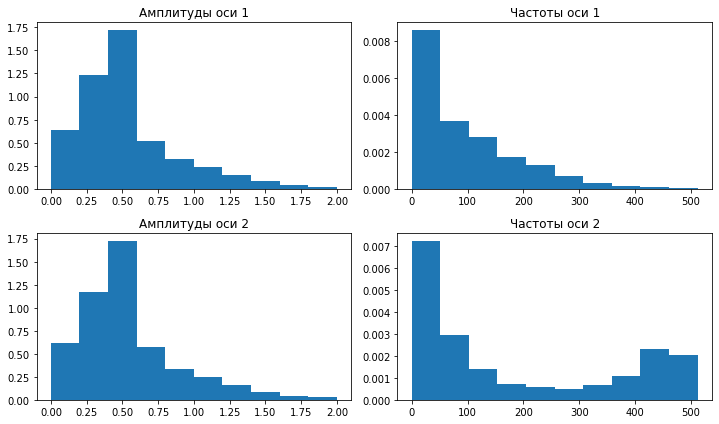

In [11]:
# Построить гистограммы для амплитуд и частот
plot_histogram(malfunction_data, n=12, figsize=(10, 6))

# 3. Предобработка данных

> Как лучше представить данные чтобы модель разработанная на их основе работала быстро и эффективно? Вместо каждой строки в исходных данных рассмотрим совокупность строк одновременно.

## Вспомогательные функции для предобработки данных

In [12]:
def generate_samples(data, n=12, slice_size=20, overlap_size=2):
    """Функция разбивает данные на партии состоящие из нескольких строк одновременно.
    При этом данные в строке заменяются на 4 числа: среднее значения для амплитуд оси 1,
    среднее значения для частот оси 1, среднее значения для амплитуд оси 2,
    среднее значения для частот оси 2.
    
    Параметры
    ----------
    data: array. Строки с амплитудами и частотами.
    n: int. Количество амплитуд и частот в строке в разрезе каждой оси.
    slice_size: int. Количество одновременно рассматриваемых строк.
    overlap_size: int. Размер перекрытия строк. 
    
    Результат
    -------
    None.
    """
    
    current_idx = 0
    output = []

    while (current_idx + slice_size) <= len(data):
        part_data = data[current_idx: current_idx+slice_size]
        mean_ampl1 = np.mean(part_data[:, 0:n], axis=0)
        mean_freq1 = np.mean(part_data[:, n:2*n], axis=0)
        mean_ampl2 = np.mean(part_data[:, 2*n:3*n], axis=0)
        mean_freq2 = np.mean(part_data[:, 3*n:4*n], axis=0)

        ampl_freq_concat = np.concatenate((mean_ampl1, mean_freq1, mean_ampl2, mean_freq2))
        output.append(ampl_freq_concat)

        current_idx = current_idx + slice_size - overlap_size

    return np.array(output)

## 3.1. Предобработка данных, соответствующих нормальной работе оборудования

In [13]:
t1 = perf_counter()
X_correct = generate_samples(correct_data)
print(f"Предобработка данных завершена за {timedelta(seconds=perf_counter()-t1)}")

# Cгенерировать вектор состоящий из нулей, этот вектор будет показывать
# принадлежность к классу - нормальная работа станка
y_correct = np.zeros(len(X_correct))

Предобработка данных завершена за 0:00:00.887945


## 3.2. Предобработка данных, диагностирующих неисправность в работе оборудования

In [14]:
t1 = perf_counter()
X_malfunction = generate_samples(malfunction_data)
print(f"Предобработка данных завершена за {timedelta(seconds=perf_counter()-t1)}")

# Cгенерировать вектор состоящий из единиц, этот вектор будет показывать
# принадлежность к классу - неисправная работа станка
y_malfunction = np.ones(len(X_malfunction))

Предобработка данных завершена за 0:00:00.871759


# 4. Создание датасета

In [15]:
# Объединить данные по нормальной и неисправной работе в один датасет
X = np.concatenate((X_correct, X_malfunction), axis=0)
y = np.concatenate((y_correct, y_malfunction), axis=0)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Разделить данные на тренировочную и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, stratify=y, shuffle=True, 
    random_state=seed
)

X shape: (58062, 48)
y shape: (58062,)


# 5. Моделирование

## Вспомогательная функция для моделирования

In [16]:
def plot_confusion_matrix(y_actual, y_pred, figsize=(7, 5)):
    """Функция строит матрицу несоответствий.
    
    Параметры
    ----------
    y_actual: array. Актуальные значения класса.
    y_pred: array. Прогнозируемые значения класса.
    figsize: tuple. Размер фигуры (ширина, высота).
    
    Результат
    -------
    None.
    """
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_norm, interpolation='none', cmap='coolwarm', aspect='equal')
    ax.figure.colorbar(im, ax=ax, shrink=0.85)
    ax.set_title('Матрица несоответствий', fontsize=14)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    categories = ['норма', 'неисправность']
    ax.set_xticklabels(categories, rotation=90)
    ax.set_yticklabels(categories)

    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        if cm_norm[i, j]!=0:
            ax.text(
                j, i,
                format(cm_norm[i, j], '.0f'),
                horizontalalignment='center', verticalalignment='center',
                color = 'white',
                fontsize=14,
                fontweight=700
            )

    ax.set_xlabel('Прогнозируемые значения', fontsize=14)
    ax.set_ylabel('Актуальные значения', fontsize=14)
    ax.grid(linestyle=':')

Обучение модели завершено за 0:00:22.017651
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      8709
         1.0       1.00      0.89      0.94      8710

    accuracy                           0.94     17419
   macro avg       0.95      0.94      0.94     17419
weighted avg       0.95      0.94      0.94     17419



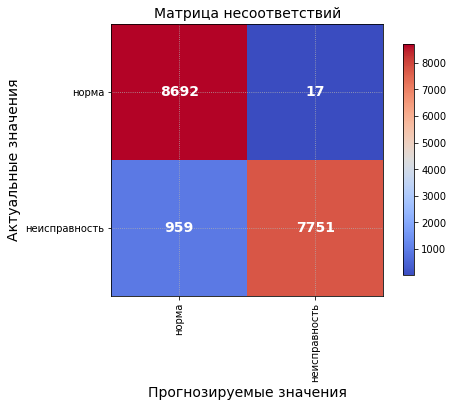

In [17]:
# Построить модель для классификации
# В ней будет использоваться Метод ближайщих соседей
# Перед использованием метода будет применяться нормализация данных MinMaxScaler
t1 = perf_counter()
pipe = Pipeline([
    ('preprocessor', MinMaxScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=15, weights='uniform', n_jobs=-1))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"Обучение модели завершено за {timedelta(seconds=perf_counter()-t1)}")

print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)

# 6. Сохранение модели

In [18]:
# Сохранить модель на диск
# для дальнейшего переиспользования
filename = 'finalized_model.pk'
pickle.dump(pipe, open(filename, 'wb'))